In [1]:
import pandas as pd
from hmmer_utils import DomainHit, reduce_hits, get_domain_hit_list, get_reduced_architectures, get_architectures_df, print_architecture, join_pfam_supfam_dfs, filter_partial_df

In [2]:
from hmmer_utils import get_strongest_hit_dict

In [3]:
from Bio import SeqIO

In [4]:
import numpy as np

In [5]:
import ast

In [6]:
DATABASES = ['bfd', 'mgnify', 'onekp', 'phytozome', 'tsa', 'uniprot']

In [7]:
DATABASES2 = ['bfd', 'mgnify_new', 'onekp', 'phytozome', 'tsa', 'uniprot']

# Reliability score

The goal is to create a score which should prioretize sequences with high chance of being functional terpene synthases.

Following criteria will be taken into account:
- **domain architecture**
- **domain hit from both Pfam and Supfam**
- **e-value of the strongest hit**
- **starts with methionin**
- similarity to characterized sequences:
    - for ESM and SNN network: 
        - there are characterized sequences in the same component
        - distance to closest sequence
    - for phylogeny: 
        - distance to closest characterized sequence in the tree

## Starts with Methionin

In [8]:
entries = []
with open("all_filtered_5_unique_no_stop.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        entries.append((record.id, record.seq[0]=='M'))

In [9]:
df = pd.DataFrame(entries, columns = ['id', 'methionin'])

In [10]:
df['methionin'].value_counts(normalize=True)

methionin
True     0.706774
False    0.293226
Name: proportion, dtype: float64

In [11]:
df.shape

(606791, 2)

## Pfam and Supfam domain architectures

### Observed architectures in characterized sequences

In [12]:
pfam_architectures_file = '../../../tps_db_analysis/architectures/pfam_architecture.txt'
supfam_architectures_file = '../../../tps_db_analysis/architectures/supfam_architecture.txt'

In [13]:
observed_pfam_architectures = []
with open(pfam_architectures_file, 'r') as in_file:
    for line in in_file.readlines():
        observed_pfam_architectures.append(line.strip())

In [14]:
observed_supfam_architectures = []
with open(supfam_architectures_file, 'r') as in_file:
    for line in in_file.readlines():
        observed_supfam_architectures.append(line.strip())

### Observed architectures in mined sequences

In [15]:
arch_df_l = []
for db in DATABASES:
    arch_df = pd.read_csv(f'../{db}_archs_summary.csv', index_col=0)
    arch_df_l.append(arch_df)

C:\Users\terca\AppData\Local\Temp\ipykernel_2748\2035735396.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  arch_df = pd.read_csv(f'../{db}_archs_summary.csv', index_col=0)
C:\Users\terca\AppData\Local\Temp\ipykernel_2748\2035735396.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  arch_df = pd.read_csv(f'../{db}_archs_summary.csv', index_col=0)
C:\Users\terca\AppData\Local\Temp\ipykernel_2748\2035735396.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  arch_df = pd.read_csv(f'../{db}_archs_summary.csv', index_col=0)


In [16]:
arch_df = pd.concat(arch_df_l)

In [17]:
arch_df['observed_pfam_architecture'] = arch_df['architecture_pfam'].isin(observed_pfam_architectures)

In [18]:
arch_df['observed_supfam_architecture'] = arch_df['architecture_supfam'].isin(observed_supfam_architectures)

In [19]:
arch_df

,id,architecture_pfam,architecture_l_pfam,architecture_supfam,architecture_l_supfam,n_doms_pfam,n_doms_supfam,contains_pfam_partial,contains_supfam_partial,observed_pfam_architecture,observed_supfam_architecture
0,bfd_106193,['PF13249.9'],['PF13249.9'],NaN,[],1,0,False,False,False,False
1,bfd_118229,"['PF13249.9', 'PF13243.9']","['PF13249.9', 'PF13243.9']",NaN,[],2,0,False,False,True,False
2,bfd_059047,"['PF13249.9', 'PF13243.9']","['PF13249.9', 'PF13243.9']",NaN,[],2,0,False,False,True,False
3,bfd_096880,['PF00494.22'],['PF00494.22'],NaN,[],1,0,False,False,True,False
4,bfd_097326,"['PF13243.9_partial', 'PF13243.9_partial']","['PF13243.9_partial', 'PF13243.9_partial']",NaN,[],2,0,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
220426,uniprot_163936,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True
220427,uniprot_188186,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True
220428,uniprot_229305,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True
220429,uniprot_181461,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True


In [20]:
arch_df.shape

(682471, 11)

In [20]:
df = df.merge(arch_df[['id', 'observed_pfam_architecture', 'observed_supfam_architecture']], how='left', on='id')

In [21]:
df.shape

(606791, 4)

There are 99,741 sequences which have both observed pfam architecture and supfam architecture.

In [22]:
arch_df[arch_df['observed_pfam_architecture'] & arch_df['observed_supfam_architecture']]

,id,architecture_pfam,architecture_l_pfam,architecture_supfam,architecture_l_supfam,n_doms_pfam,n_doms_supfam,contains_pfam_partial,contains_supfam_partial,observed_pfam_architecture,observed_supfam_architecture
7,bfd_081814,"['PF01397.24', 'PF03936.19']","['PF01397.24', 'PF03936.19']",['0048261'],['0048261'],2,1,False,False,True,True
10,bfd_018736,['PF00494.22'],['PF00494.22'],['0046340_partial'],['0046340_partial'],1,1,False,True,True,True
13,bfd_049008,"['PF01397.24', 'PF03936.19']","['PF01397.24', 'PF03936.19']",['0053355'],['0053355'],2,1,False,False,True,True
16,bfd_001499,['PF00494.22'],['PF00494.22'],['0046340'],['0046340'],1,1,False,False,True,True
29,bfd_025594,['PF00494.22'],['PF00494.22'],['0048806'],['0048806'],1,1,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
93529,uniprot_070202,['PF19086.3'],['PF19086.3'],['0047573'],['0047573'],1,1,False,False,True,True
93530,uniprot_086218,['PF06330.14'],['PF06330.14'],['0047573'],['0047573'],1,1,False,False,True,True
93531,uniprot_061294,['PF00494.22'],['PF00494.22'],['0046340_partial'],['0046340_partial'],1,1,False,True,True,True
93532,uniprot_025064,['PF06330.14'],['PF06330.14'],['0047573'],['0047573'],1,1,False,False,True,True


There are 203,359 sequences with observed Pfam architecture.

In [23]:
arch_df[arch_df['observed_pfam_architecture']]

,id,architecture_pfam,architecture_l_pfam,architecture_supfam,architecture_l_supfam,n_doms_pfam,n_doms_supfam,contains_pfam_partial,contains_supfam_partial,observed_pfam_architecture,observed_supfam_architecture
1,bfd_118229,"['PF13249.9', 'PF13243.9']","['PF13249.9', 'PF13243.9']",NaN,[],2,0,False,False,True,False
2,bfd_059047,"['PF13249.9', 'PF13243.9']","['PF13249.9', 'PF13243.9']",NaN,[],2,0,False,False,True,False
3,bfd_096880,['PF00494.22'],['PF00494.22'],NaN,[],1,0,False,False,True,False
4,bfd_097326,"['PF13243.9_partial', 'PF13243.9_partial']","['PF13243.9_partial', 'PF13243.9_partial']",NaN,[],2,0,True,False,True,False
7,bfd_081814,"['PF01397.24', 'PF03936.19']","['PF01397.24', 'PF03936.19']",['0048261'],['0048261'],2,1,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
93530,uniprot_086218,['PF06330.14'],['PF06330.14'],['0047573'],['0047573'],1,1,False,False,True,True
93531,uniprot_061294,['PF00494.22'],['PF00494.22'],['0046340_partial'],['0046340_partial'],1,1,False,True,True,True
93532,uniprot_025064,['PF06330.14'],['PF06330.14'],['0047573'],['0047573'],1,1,False,False,True,True
93533,uniprot_054707,"['PF01397.24', 'PF03936.19', 'PF03936.19_parti...","['PF01397.24', 'PF03936.19', 'PF03936.19_parti...","['0046340_partial', '0053355']","['0046340_partial', '0053355']",3,2,True,True,True,False


There are 551,331 sequences with observed Supfam architecture.

In [24]:
arch_df[arch_df['observed_supfam_architecture']]

,id,architecture_pfam,architecture_l_pfam,architecture_supfam,architecture_l_supfam,n_doms_pfam,n_doms_supfam,contains_pfam_partial,contains_supfam_partial,observed_pfam_architecture,observed_supfam_architecture
5,bfd_126300,"['PF01397.24', 'PF03936.19_partial', 'PF03936....","['PF01397.24', 'PF03936.19_partial', 'PF03936....","['0041184', '0048261']","['0041184', '0048261']",4,2,True,False,False,True
6,bfd_203259,['PF00494.22_partial'],['PF00494.22_partial'],['0046340'],['0046340'],1,1,True,False,False,True
7,bfd_081814,"['PF01397.24', 'PF03936.19']","['PF01397.24', 'PF03936.19']",['0048261'],['0048261'],2,1,False,False,True,True
9,bfd_221989,"['PF03936.19_partial', 'PF03936.19_partial']","['PF03936.19_partial', 'PF03936.19_partial']",['0046340'],['0046340'],2,1,True,False,False,True
10,bfd_018736,['PF00494.22'],['PF00494.22'],['0046340_partial'],['0046340_partial'],1,1,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
220426,uniprot_163936,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True
220427,uniprot_188186,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True
220428,uniprot_229305,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True
220429,uniprot_181461,NaN,[],['0046340'],['0046340'],0,1,False,False,False,True


## E-value of the strongest hit

### Pfam

In [25]:
df_l = []
for db in DATABASES2:
    hits =  get_domain_hit_list(f'../pfam_architectures/{db}_hmmscan.tsv')
    strongest_hits = get_strongest_hit_dict(hits)
    hit_df = pd.DataFrame([(sequence, hit.domain_cevalue, hit.domain_accession) for sequence, hit in strongest_hits.items()], columns = ['id','strongest_pfam_hit_cevalue','strongest_pfam_domain'])
    df_l.append(hit_df)

In [26]:
pfam_hits_df = pd.concat(df_l)

<Axes: >

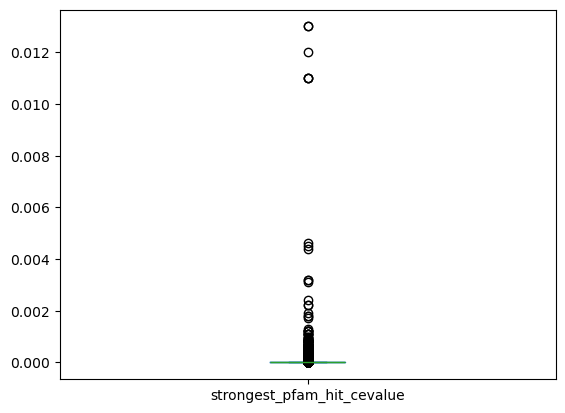

In [27]:
pfam_hits_df['strongest_pfam_hit_cevalue'].plot.box()

In [28]:
pfam_hits_df['strongest_pfam_hit_cevalue'].mean()

2.0135526739639957e-06

In [29]:
pfam_hits_df.iloc[pfam_hits_df['strongest_pfam_hit_cevalue'].idxmax()]

id                            bfd_194314
strongest_pfam_hit_cevalue         0.013
strongest_pfam_domain         PF00494.22
Name: 11072, dtype: object

In [30]:
pfam_hits_df['strongest_pfam_hit_cevalue_neg_log'] = pfam_hits_df['strongest_pfam_hit_cevalue'].apply(lambda x: -np.log(x))

<Axes: >

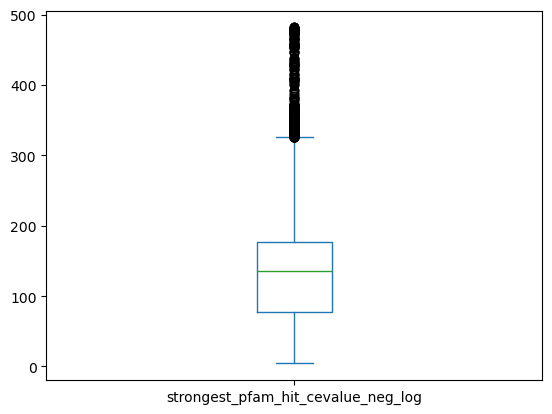

In [31]:
pfam_hits_df['strongest_pfam_hit_cevalue_neg_log'].plot.box()

<Axes: ylabel='Frequency'>

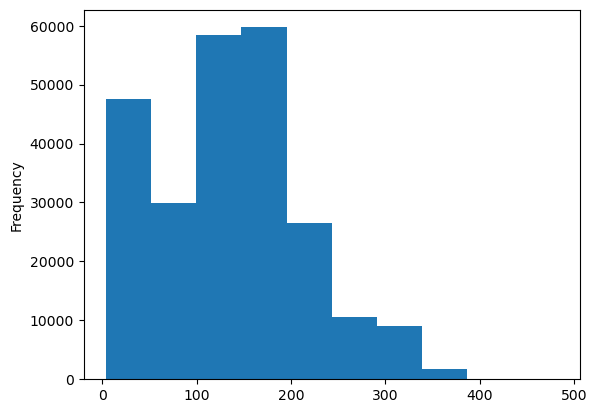

In [32]:
pfam_hits_df['strongest_pfam_hit_cevalue_neg_log'].plot.hist()

In [33]:
M = pfam_hits_df['strongest_pfam_hit_cevalue_neg_log'].max()
M

481.7850116111972

In [34]:
m = pfam_hits_df['strongest_pfam_hit_cevalue_neg_log'].min()
m

4.3428059215206005

In [35]:
def normalize(value, min_value, max_value):
    if max_value == min_value:
        return 0.0
    normalized_value = (value - min_value) / (max_value - min_value)
    return normalized_value

In [36]:
pfam_hits_df['strongest_pfam_hit_cevalue_neg_log_norm'] = pfam_hits_df['strongest_pfam_hit_cevalue_neg_log'].apply(lambda x: normalize(x, m, M))

In [37]:
pfam_hits_df

,id,strongest_pfam_hit_cevalue,strongest_pfam_domain,strongest_pfam_hit_cevalue_neg_log,strongest_pfam_hit_cevalue_neg_log_norm
0,bfd_058619,1.900000e-54,PF00494.22,123.697741,0.249988
1,bfd_075059,7.300000e-64,PF00494.22,145.377572,0.295397
2,bfd_099490,1.400000e-140,PF13243.9,322.025441,0.665384
3,bfd_253148,5.700000e-06,PF19086.3,12.075044,0.016195
4,bfd_074632,5.900000e-67,PF00494.22,152.498249,0.310311
...,...,...,...,...,...
93531,uniprot_106442,4.300000e-48,PF13243.9,109.065469,0.219341
93532,uniprot_016793,1.100000e-93,PF03936.19,214.045103,0.439220
93533,uniprot_043164,4.500000e-70,PF00494.22,159.676879,0.325346
93534,uniprot_108838,8.900000e-50,PF19086.3,112.943203,0.227463


<Axes: >

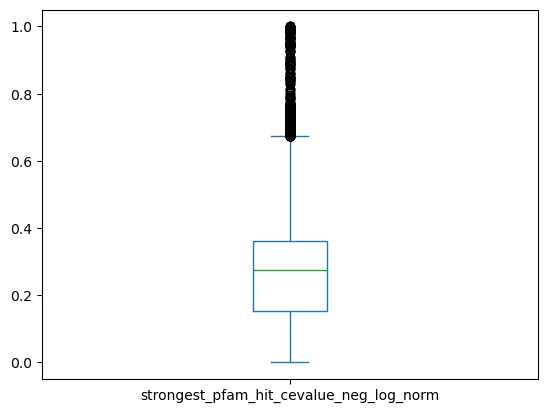

In [38]:
pfam_hits_df['strongest_pfam_hit_cevalue_neg_log_norm'].plot.box()

In [39]:
df = df.merge(pfam_hits_df[['id','strongest_pfam_hit_cevalue', 'strongest_pfam_hit_cevalue_neg_log_norm']], how='left', on='id')

### Supfam

In [40]:
df_l = []
for db in DATABASES2:
    hits =  get_domain_hit_list(f'../supfam_architectures/{db}_hmmscan.tsv')
    strongest_hits = get_strongest_hit_dict(hits)
    hit_df = pd.DataFrame([(sequence, hit.domain_cevalue, hit.domain_name) for sequence, hit in strongest_hits.items()], columns = ['id','strongest_supfam_hit_cevalue','strongest_supfam_domain'])
    df_l.append(hit_df)

In [41]:
supfam_hits_df = pd.concat(df_l)

<Axes: >

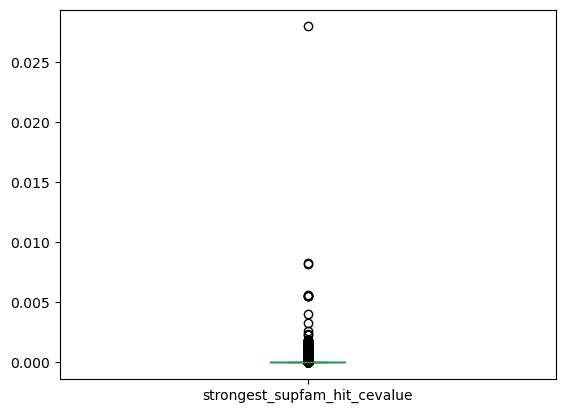

In [42]:
supfam_hits_df['strongest_supfam_hit_cevalue'].plot.box()

In [43]:
supfam_hits_df['strongest_supfam_hit_cevalue'].mean()

1.2328756307930695e-06

In [44]:
supfam_hits_df['strongest_supfam_hit_cevalue'].min()

2.2e-142

In [45]:
supfam_hits_df['strongest_supfam_hit_cevalue'].max()

0.028

In [46]:
supfam_hits_df.iloc[supfam_hits_df['strongest_supfam_hit_cevalue'].idxmax()]

id                              bfd_029263
strongest_supfam_hit_cevalue         0.028
strongest_supfam_domain            0053355
Name: 99935, dtype: object

In [47]:
supfam_hits_df['strongest_supfam_hit_cevalue_neg_log'] = supfam_hits_df['strongest_supfam_hit_cevalue'].apply(lambda x: -np.log(x))

<Axes: >

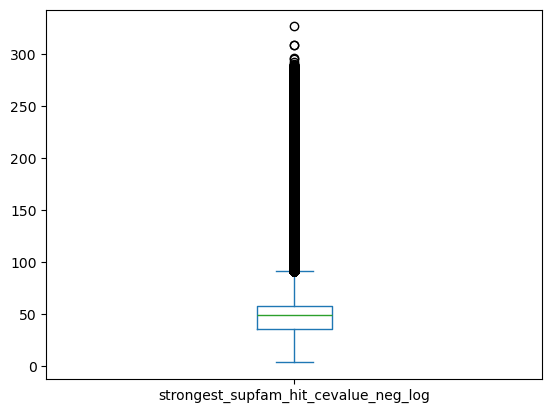

In [48]:
supfam_hits_df['strongest_supfam_hit_cevalue_neg_log'].plot.box()

<Axes: ylabel='Frequency'>

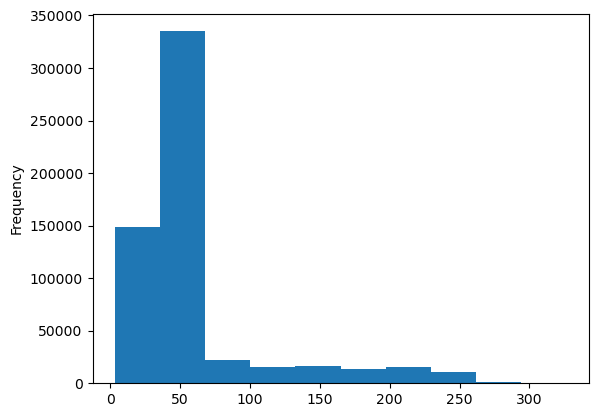

In [49]:
supfam_hits_df['strongest_supfam_hit_cevalue_neg_log'].plot.hist()

In [50]:
M = supfam_hits_df['strongest_supfam_hit_cevalue_neg_log'].max()
M

326.1786258447902

In [51]:
m = supfam_hits_df['strongest_supfam_hit_cevalue_neg_log'].min()
m

3.575550768806933

In [52]:
supfam_hits_df['strongest_supfam_hit_cevalue_neg_log_norm'] = supfam_hits_df['strongest_supfam_hit_cevalue_neg_log'].apply(lambda x: normalize(x, m, M))

<Axes: >

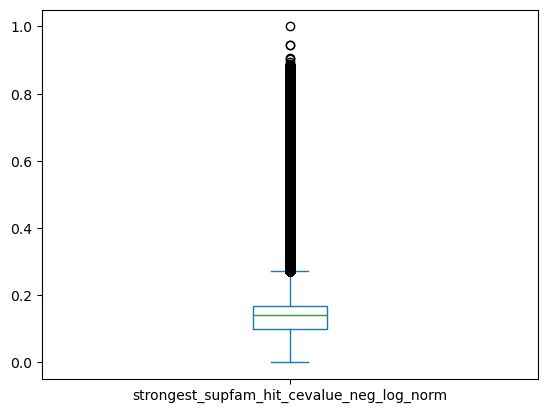

In [53]:
supfam_hits_df['strongest_supfam_hit_cevalue_neg_log_norm'].plot.box()

In [54]:
df = df.merge(supfam_hits_df[['id','strongest_supfam_hit_cevalue', 'strongest_supfam_hit_cevalue_neg_log_norm']], how='left', on='id')

## Hit from both Pfam and Supfam 

In [55]:
df['has_pfam_hit'] = ~df['strongest_pfam_hit_cevalue'].isna()
df['has_supfam_hit'] = ~df['strongest_supfam_hit_cevalue'].isna()

In [64]:
df['has_pfam_and_supfam_hit'] = df['has_pfam_hit']&df['has_supfam_hit']

## Results so far

In [56]:
df

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit
0,onekp_000000,False,True,True,5.700000e-87,0.406838,2.700000e-76,0.528289,True,True
1,onekp_000003,True,False,False,1.400000e-41,0.187932,NaN,NaN,True,False
2,onekp_000004,False,True,True,3.100000e-110,0.519037,3.800000e-108,0.755630,True,True
3,onekp_000006,False,True,True,2.500000e-106,0.500197,2.300000e-110,0.771462,True,True
4,onekp_000007,False,True,True,5.200000e-96,0.450435,4.000000e-94,0.655546,True,True
...,...,...,...,...,...,...,...,...,...,...
606786,bfd_273443,True,False,True,NaN,NaN,4.100000e-12,0.070193,False,True
606787,bfd_273498,False,False,True,NaN,NaN,6.800000e-15,0.090037,False,True
606788,bfd_273500,False,False,True,NaN,NaN,3.700000e-15,0.091924,False,True
606789,bfd_273502,True,False,True,NaN,NaN,6.700000e-15,0.090083,False,True


In [57]:
df[['strongest_pfam_hit_cevalue_neg_log_norm', 'strongest_supfam_hit_cevalue_neg_log_norm']] = df[['strongest_pfam_hit_cevalue_neg_log_norm','strongest_supfam_hit_cevalue_neg_log_norm']].fillna(value=0)


In [58]:
df[['methionin','observed_pfam_architecture','observed_supfam_architecture','has_pfam_hit','has_supfam_hit','has_pfam_and_supfam_hit']] = df[['methionin','observed_pfam_architecture','observed_supfam_architecture','has_pfam_hit','has_supfam_hit']].fillna(False).astype(int)

In [59]:
df

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit
0,onekp_000000,0,1,1,5.700000e-87,0.406838,2.700000e-76,0.528289,1,1
1,onekp_000003,1,0,0,1.400000e-41,0.187932,NaN,0.000000,1,0
2,onekp_000004,0,1,1,3.100000e-110,0.519037,3.800000e-108,0.755630,1,1
3,onekp_000006,0,1,1,2.500000e-106,0.500197,2.300000e-110,0.771462,1,1
4,onekp_000007,0,1,1,5.200000e-96,0.450435,4.000000e-94,0.655546,1,1
...,...,...,...,...,...,...,...,...,...,...
606786,bfd_273443,1,0,1,NaN,0.000000,4.100000e-12,0.070193,0,1
606787,bfd_273498,0,0,1,NaN,0.000000,6.800000e-15,0.090037,0,1
606788,bfd_273500,0,0,1,NaN,0.000000,3.700000e-15,0.091924,0,1
606789,bfd_273502,1,0,1,NaN,0.000000,6.700000e-15,0.090083,0,1


In [59]:
df['methionin'].value_counts(normalize=True)

methionin
1    0.706774
0    0.293226
Name: proportion, dtype: float64

In [60]:
df['observed_pfam_architecture'].value_counts(normalize=True)

observed_pfam_architecture
0    0.696845
1    0.303155
Name: proportion, dtype: float64

In [61]:
df['observed_supfam_architecture'].value_counts(normalize=True)

observed_supfam_architecture
1    0.803389
0    0.196611
Name: proportion, dtype: float64

In [62]:
df['strongest_pfam_hit_cevalue_neg_log_norm'].mean()

0.09938058417035128

In [63]:
df['strongest_supfam_hit_cevalue_neg_log_norm'].mean()

0.1533498006891141

In [64]:
(df['strongest_pfam_hit_cevalue_neg_log_norm'] > df['strongest_pfam_hit_cevalue_neg_log_norm'].mean()).value_counts(normalize=True)

strongest_pfam_hit_cevalue_neg_log_norm
False    0.705686
True     0.294314
Name: proportion, dtype: float64

In [65]:
(df['strongest_supfam_hit_cevalue_neg_log_norm'] > df['strongest_supfam_hit_cevalue_neg_log_norm'].mean()).value_counts(normalize=True)

strongest_supfam_hit_cevalue_neg_log_norm
False    0.688649
True     0.311351
Name: proportion, dtype: float64

### Sequences with high reliability

In [66]:
df[(df['methionin']) & (df['observed_pfam_architecture']) & (df['observed_supfam_architecture']) & (df['strongest_pfam_hit_cevalue'] < 1e-07) & (df['strongest_supfam_hit_cevalue'] < 1e-07)]

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit
40,onekp_000072,1,1,1,2.300000e-76,0.355689,5.300000e-87,0.604711,1,1
60,onekp_000114,1,1,1,7.000000e-72,0.334066,8.800000e-72,0.496077,1,1
68,onekp_000125,1,1,1,3.600000e-60,0.277586,7.000000e-68,0.468236,1,1
69,onekp_000126,1,1,1,6.800000e-68,0.314836,1.000000e-73,0.509955,1,1
105,onekp_000180,1,1,1,3.400000e-59,0.272883,4.100000e-62,0.427069,1,1
...,...,...,...,...,...,...,...,...,...,...
583538,bfd_243116,1,1,1,6.500000e-09,0.030388,8.700000e-25,0.160649,1,1
586981,bfd_247450,1,1,1,4.400000e-08,0.026383,3.700000e-13,0.077649,1,1
592389,bfd_254970,1,1,1,2.600000e-08,0.027485,1.300000e-24,0.159404,1,1
606772,bfd_273330,1,1,1,1.300000e-08,0.028937,7.800000e-24,0.153850,1,1


In [67]:
df[(df['methionin']) & (df['observed_pfam_architecture']) & (df['observed_supfam_architecture']) & (df['strongest_pfam_hit_cevalue'] < 1e-07) & (df['strongest_supfam_hit_cevalue'] < 1e-07)]['id'].apply(lambda x: x.split('_')[0]).value_counts(normalize=True)*100

id
uniprot      71.212121
tsa          13.965819
phytozome    11.143141
bfd           1.688459
mgnify        1.472254
onekp         0.518206
Name: proportion, dtype: float64

In [65]:
df.columns

Index(['id', 'methionin', 'observed_pfam_architecture',
       'observed_supfam_architecture', 'strongest_pfam_hit_cevalue',
       'strongest_pfam_hit_cevalue_neg_log_norm',
       'strongest_supfam_hit_cevalue',
       'strongest_supfam_hit_cevalue_neg_log_norm', 'has_pfam_hit',
       'has_supfam_hit', 'has_pfam_and_supfam_hit'],
      dtype='object')

# Reliability score

In [67]:
df['reliability_score'] = df['methionin'] + df['observed_pfam_architecture'] + df['observed_supfam_architecture'] + df['has_pfam_and_supfam_hit'] + df['strongest_pfam_hit_cevalue_neg_log_norm'] + df['strongest_supfam_hit_cevalue_neg_log_norm']

<Axes: ylabel='Frequency'>

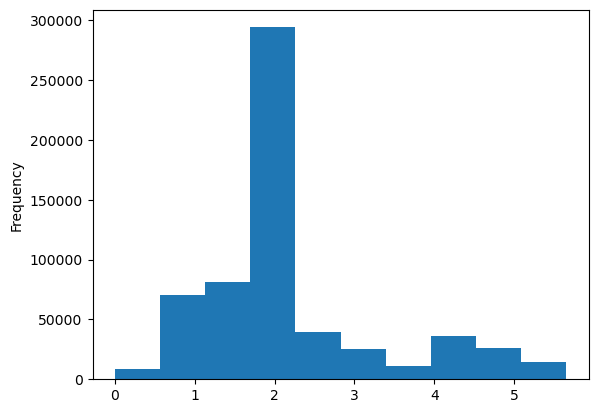

In [68]:
df['reliability_score'].plot.hist()

In [69]:
df[df['reliability_score']>5]

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,has_pfam_and_supfam_hit,reliability_score
260,onekp_000462,1,1,1,7.700000e-100,0.468904,3.400000e-99,0.691737,1,1,1,5.160641
298,onekp_000533,1,1,1,1.900000e-96,0.452544,8.000000e-94,0.653397,1,1,1,5.105941
371,onekp_000662,1,1,1,5.400000e-102,0.479293,1.600000e-106,0.744037,1,1,1,5.223329
372,onekp_000663,1,1,1,7.400000e-103,0.483455,4.200000e-108,0.755320,1,1,1,5.238775
373,onekp_000664,1,1,1,3.300000e-104,0.489970,5.600000e-108,0.754428,1,1,1,5.244398
...,...,...,...,...,...,...,...,...,...,...,...,...
494016,bfd_124452,1,1,1,4.800000e-98,0.460248,2.800000e-90,0.628102,1,1,1,5.088350
494018,bfd_124475,1,1,1,9.500000e-109,0.511869,1.500000e-108,0.758512,1,1,1,5.270380
494025,bfd_124491,1,1,1,1.500000e-91,0.428925,1.200000e-82,0.573628,1,1,1,5.002553
494045,bfd_124620,1,1,1,1.200000e-98,0.463152,1.000000e-84,0.588468,1,1,1,5.051620


In [70]:
df.to_csv('reliability_score.csv')

# Below is not used

## Similarity to characterized sequences

### SSN

Sequence similarity measured by the sequence alignment to the characterized sequences.

In [68]:
ss = pd.read_csv('all_filtered_5_most_similar.csv', names=['id','ss_closest_char_tps','ss'], sep=',')

<Axes: >

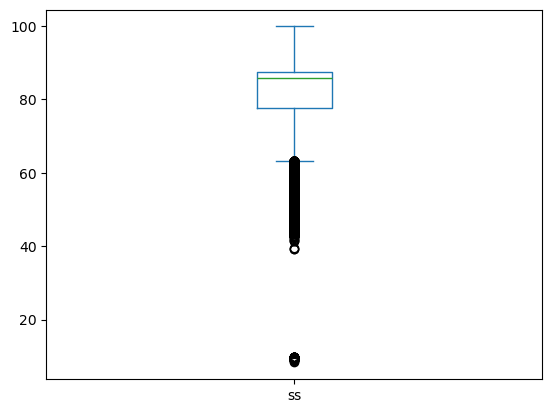

In [69]:
ss['ss'].plot.box()

In [70]:
M=ss['ss'].max()

In [71]:
m=ss['ss'].min()

In [72]:
ss['ss_distance_score'] = ss['ss'].apply(lambda x: normalize(x,m,M))

In [73]:
ss

,id,ss_closest_char_tps,ss,ss_distance_score
0,onekp_000000,Q9AR67,72.727,0.703360
1,onekp_000003,A4FG19,87.500,0.864722
2,onekp_000004,U3KYL2,87.500,0.864722
3,onekp_000006,A1JH12,55.780,0.518252
4,onekp_000007,W0FFD7,52.641,0.483965
...,...,...,...,...
606786,bfd_273443,Q9LRZ6,83.333,0.819207
606787,bfd_273498,A0A7G5KLV0,87.500,0.864722
606788,bfd_273500,BDI63105.1,85.714,0.845214
606789,bfd_273502,K7TR87,87.500,0.864722


In [74]:
df = df.merge(ss, how='left', on='id')

In [75]:
df

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,ss_closest_char_tps,ss,ss_distance_score
0,onekp_000000,0,1,1,5.700000e-87,0.406838,2.700000e-76,0.528289,1,1,Q9AR67,72.727,0.703360
1,onekp_000003,1,0,0,1.400000e-41,0.187932,NaN,0.000000,1,0,A4FG19,87.500,0.864722
2,onekp_000004,0,1,1,3.100000e-110,0.519037,3.800000e-108,0.755630,1,1,U3KYL2,87.500,0.864722
3,onekp_000006,0,1,1,2.500000e-106,0.500197,2.300000e-110,0.771462,1,1,A1JH12,55.780,0.518252
4,onekp_000007,0,1,1,5.200000e-96,0.450435,4.000000e-94,0.655546,1,1,W0FFD7,52.641,0.483965
...,...,...,...,...,...,...,...,...,...,...,...,...,...
606786,bfd_273443,1,0,1,NaN,0.000000,4.100000e-12,0.070193,0,1,Q9LRZ6,83.333,0.819207
606787,bfd_273498,0,0,1,NaN,0.000000,6.800000e-15,0.090037,0,1,A0A7G5KLV0,87.500,0.864722
606788,bfd_273500,0,0,1,NaN,0.000000,3.700000e-15,0.091924,0,1,BDI63105.1,85.714,0.845214
606789,bfd_273502,1,0,1,NaN,0.000000,6.700000e-15,0.090083,0,1,K7TR87,87.500,0.864722


### ESM

In [76]:
#X = pd.read_csv('esm_embeddings.tsv', sep='\t', header=None)

In [77]:
#names = pd.read_csv('../esm/esm_embeddings_names.tsv', sep='\t', header=None)

In [78]:
#names[names[0]=='tsa_000113.pt']

In [79]:
# FIXME: missing the distances for some sequences!!!

In [80]:
# sequences which are missing the esm data
#len(df[df['esm_closest_char_tps'].isna()]['id'].tolist())

In [81]:
esm_distances = pd.read_csv('esm_min_distances_anno.csv', index_col=0)

In [82]:
esm_distances = esm_distances[['id','min_distance','closest_char_tps_id']] 

In [83]:
esm_distances.rename(columns={'closest_char_tps_id': 'esm_closest_char_tps', 'min_distance': 'esm_distance'}, inplace=True)

In [84]:
#distances = pd.read_csv('../esm/min_distances.csv', index_col=0)

In [85]:
#distances.rename(columns={'name': 'id', 'seq_with_min_distance_name': 'esm_closest_char_tps', 'min_distance': 'esm_distance'}, inplace=True)

In [86]:
#distances = distances[['id', 'esm_closest_char_tps', 'esm_distance']]

In [87]:
#distances['esm_closest_char_tps'] = distances['esm_closest_char_tps'].apply(lambda x: x.strip('.pt'))

<Axes: >

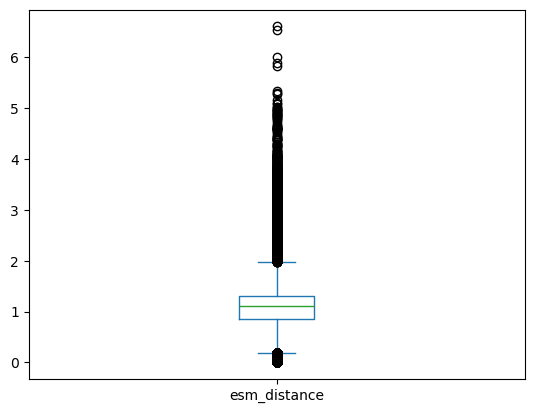

In [88]:
esm_distances['esm_distance'].plot.box()

In [89]:
m = esm_distances['esm_distance'].min()
M = esm_distances['esm_distance'].max()
esm_distances['esm_distance_norm'] = esm_distances['esm_distance'].apply(lambda x: normalize(x, m, M))

In [90]:
esm_distances

,id,esm_distance,esm_closest_char_tps,esm_distance_norm
0,mgnify_new_164215,1.307798,P21684,0.197753
1,uniprot_159215,1.301663,P21684,0.196826
2,bfd_207912,1.192460,A0A7D0AGU9,0.180313
3,mgnify_new_012702,0.930488,A0A0B4GN88,0.140700
4,onekp_011005,0.547116,P08196,0.082730
...,...,...,...,...
606786,bfd_268064,1.226685,P21684,0.185488
606787,uniprot_068648,0.678793,Q9X839,0.102641
606788,uniprot_256676,1.126783,A0A7D0AGU9,0.170382
606789,uniprot_035222,1.473279,G2P5T1,0.222776


<Axes: >

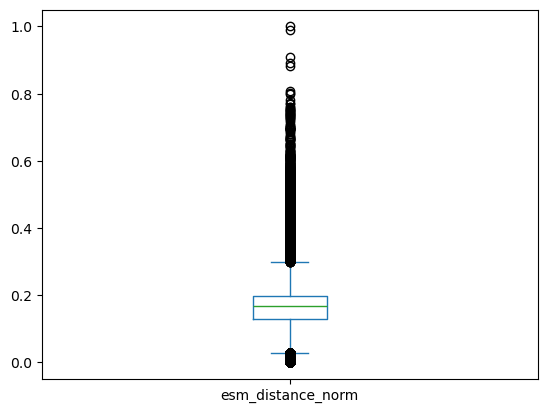

In [91]:
esm_distances['esm_distance_norm'].plot.box()

In [92]:
df = df.merge(esm_distances, how='left', on='id')

In [93]:
df['esm_closeness_score']= 1-df['esm_distance_norm']

In [94]:
df[df['ss_closest_char_tps']==df['esm_closest_char_tps']]

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,ss_closest_char_tps,ss,ss_distance_score,esm_distance,esm_closest_char_tps,esm_distance_norm,esm_closeness_score
39,onekp_000061,0,1,0,3.900000e-48,0.219546,NaN,0.000000,1,0,D0VFU8,83.636,0.822516,0.320085,D0VFU8,0.048400,0.951600
96,onekp_000169,0,1,1,8.500000e-84,0.391533,4.900000e-86,0.597817,1,1,A0A6B8N4Y9,84.164,0.828283,0.445114,A0A6B8N4Y9,0.067306,0.932694
104,onekp_000179,0,1,1,4.100000e-73,0.340010,3.200000e-77,0.534900,1,1,A0A6C0TL59,72.857,0.704780,0.504263,A0A6C0TL59,0.076250,0.923750
111,onekp_000189,0,1,1,2.300000e-110,0.519662,1.100000e-103,0.723785,1,1,G8H5M8,76.306,0.742452,0.444955,G8H5M8,0.067282,0.932718
112,onekp_000190,0,1,1,2.100000e-104,0.490916,2.100000e-105,0.736056,1,1,G1JUH5,84.249,0.829212,0.472711,G1JUH5,0.071479,0.928521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586383,bfd_246616,0,0,1,NaN,0.000000,2.200000e-21,0.136360,0,1,P21684,77.778,0.758531,1.272454,P21684,0.192409,0.807591
595718,bfd_259403,0,0,1,NaN,0.000000,1.400000e-21,0.137761,0,1,P21684,80.000,0.782801,1.317532,P21684,0.199225,0.800775
604750,bfd_270471,0,0,1,NaN,0.000000,2.200000e-20,0.129223,0,1,P21684,76.923,0.749192,1.974275,P21684,0.298532,0.701468
605733,bfd_271532,0,0,1,NaN,0.000000,5.900000e-15,0.090477,0,1,P21684,77.778,0.758531,1.137235,P21684,0.171962,0.828038


### Phylogeny

Since we created the phylogenetic tree only for the representative sequences, we give the unrepresented sequences the same distance as their representatives.

In [95]:
phylo_df = pd.read_csv('../phylogenetics/tree/clustalo/trimal_gt_80_cons_60/min_distances.csv', index_col=0)

In [96]:
phylo_df = phylo_df.rename(columns={'Unnamed: 0': 'id'})

In [97]:
phylo_df.head()

,id,distance_to_closest_characterized,closest_characterized_leaf
0,uniprot_131927,5.041915,B3TPQ7
1,uniprot_250979,4.527023,B3TPQ7
2,mgnify_new_191805,4.245652,B3TPQ7
3,uniprot_059474,8.548534,B3TPQ7
4,uniprot_235390,5.579579,B3TPQ7


In [98]:
m = phylo_df['distance_to_closest_characterized'].min()

In [99]:
M = phylo_df['distance_to_closest_characterized'].max()

In [100]:
phylo_df['phylo_distance_score'] = phylo_df['distance_to_closest_characterized'].apply(lambda x: 1-normalize(x, m, M))

#### Unrepresented sequences

In [101]:
cluster_info = '../clustering/50_identity/all_filtered_5_unique_no_stop_50_clstr_info.tsv'
cluster_info_df = pd.read_csv(cluster_info, sep='\t', index_col=0)

In [102]:
cluster_info_df['cluster_members'] = cluster_info_df['cluster_members'].apply(lambda x:  ast.literal_eval(x))

In [103]:
cluster_info_df.loc[856]

cluster_name                                                             Cluster_856
cluster_size                                                                      21
cluster_representative                                                uniprot_069591
cluster_members_with_identities    onekp_000000 (54.46), onekp_003193 (54.34), ts...
average_identity                                                           58.800952
superkingdoms                      ['Eukaryota', 'Eukaryota', 'Eukaryota', 'Eukar...
Eukaryota_perc                                                              0.952381
Metagenome_perc                                                                  0.0
Archaea_perc                                                                     0.0
Bacteria_perc                                                                    0.0
Viruses_perc                                                                     0.0
PF06330.14_perc                                                  

In [104]:
cluster_info_df2 = cluster_info_df[['cluster_members', 'cluster_representative']].explode('cluster_members')

In [105]:
cluster_info_df2[cluster_info_df2['cluster_members'] == 'tsa_060479']

,cluster_members,cluster_representative


In [106]:
#cluster_info_df2[cluster_info_df2['cluster_members'] == 'onekp_000000']

In [107]:
#phylo_df[phylo_df['id'] == 'uniprot_069591']

In [108]:
#cluster_info_df2.iloc[0]['cluster_representative']

In [109]:
cluster_info_df3 = cluster_info_df2.merge(phylo_df, how='outer', left_on='cluster_representative', right_on='id')

In [110]:
cluster_info_df3.shape

(606792, 6)

In [111]:
#cluster_info_df3[cluster_info_df3['cluster_members'] == 'onekp_000000']

In [112]:
#cluster_info_df3.iloc[0]['id']

In [113]:
#df.iloc[0]['id']

In [114]:
df = df.merge(cluster_info_df3, how='left', left_on='id', right_on='cluster_members')

In [115]:
df

,id_x,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,...,esm_distance,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,cluster_members,cluster_representative,id_y,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score
0,onekp_000000,0,1,1,5.700000e-87,0.406838,2.700000e-76,0.528289,1,1,...,0.609776,M4HZ33,0.092205,0.907795,onekp_000000,uniprot_069591,uniprot_069591,1.432650,A0A7S5L3H2,0.889871
1,onekp_000003,1,0,0,1.400000e-41,0.187932,NaN,0.000000,1,0,...,0.644386,Q9SLW3,0.097438,0.902562,onekp_000003,uniprot_074612,uniprot_074612,0.062775,Q6Z2X6,0.995174
2,onekp_000004,0,1,1,3.100000e-110,0.519037,3.800000e-108,0.755630,1,1,...,0.582675,Q4VP11,0.088107,0.911893,onekp_000004,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255
3,onekp_000006,0,1,1,2.500000e-106,0.500197,2.300000e-110,0.771462,1,1,...,0.524533,M4HZ33,0.079315,0.920685,onekp_000006,uniprot_087438,uniprot_087438,0.370789,A1JH12,0.971497
4,onekp_000007,0,1,1,5.200000e-96,0.450435,4.000000e-94,0.655546,1,1,...,0.624189,U3LVL5,0.094384,0.905616,onekp_000007,uniprot_089751,uniprot_089751,1.330082,B9S9Z3,0.897755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606786,bfd_273443,1,0,1,NaN,0.000000,4.100000e-12,0.070193,0,1,...,1.123627,Q7XYS8,0.169905,0.830095,bfd_273443,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711
606787,bfd_273498,0,0,1,NaN,0.000000,6.800000e-15,0.090037,0,1,...,1.308006,Q7XYS8,0.197785,0.802215,bfd_273498,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711
606788,bfd_273500,0,0,1,NaN,0.000000,3.700000e-15,0.091924,0,1,...,1.585851,P0C565,0.239798,0.760202,bfd_273500,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711
606789,bfd_273502,1,0,1,NaN,0.000000,6.700000e-15,0.090083,0,1,...,1.427118,P0C565,0.215796,0.784204,bfd_273502,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711


In [116]:
phylo_df[phylo_df['id'] == 'tsa_060479']

,id,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score
356,tsa_060479,2.838501,A0A8F4PPI6,0.781802


In [117]:
df.iloc[50730]['id_x']

'tsa_060479'

In [118]:
df[df['phylo_distance_score'].isna()]

,id_x,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,...,esm_distance,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,cluster_members,cluster_representative,id_y,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score
50730,tsa_060479,0,0,1,NaN,0.0,6.500000e-15,0.090177,0,1,...,0.892795,A0A140AZ72,0.135,0.865,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
df.shape

(606791, 23)

## Score

In [120]:
df

,id_x,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,...,esm_distance,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,cluster_members,cluster_representative,id_y,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score
0,onekp_000000,0,1,1,5.700000e-87,0.406838,2.700000e-76,0.528289,1,1,...,0.609776,M4HZ33,0.092205,0.907795,onekp_000000,uniprot_069591,uniprot_069591,1.432650,A0A7S5L3H2,0.889871
1,onekp_000003,1,0,0,1.400000e-41,0.187932,NaN,0.000000,1,0,...,0.644386,Q9SLW3,0.097438,0.902562,onekp_000003,uniprot_074612,uniprot_074612,0.062775,Q6Z2X6,0.995174
2,onekp_000004,0,1,1,3.100000e-110,0.519037,3.800000e-108,0.755630,1,1,...,0.582675,Q4VP11,0.088107,0.911893,onekp_000004,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255
3,onekp_000006,0,1,1,2.500000e-106,0.500197,2.300000e-110,0.771462,1,1,...,0.524533,M4HZ33,0.079315,0.920685,onekp_000006,uniprot_087438,uniprot_087438,0.370789,A1JH12,0.971497
4,onekp_000007,0,1,1,5.200000e-96,0.450435,4.000000e-94,0.655546,1,1,...,0.624189,U3LVL5,0.094384,0.905616,onekp_000007,uniprot_089751,uniprot_089751,1.330082,B9S9Z3,0.897755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606786,bfd_273443,1,0,1,NaN,0.000000,4.100000e-12,0.070193,0,1,...,1.123627,Q7XYS8,0.169905,0.830095,bfd_273443,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711
606787,bfd_273498,0,0,1,NaN,0.000000,6.800000e-15,0.090037,0,1,...,1.308006,Q7XYS8,0.197785,0.802215,bfd_273498,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711
606788,bfd_273500,0,0,1,NaN,0.000000,3.700000e-15,0.091924,0,1,...,1.585851,P0C565,0.239798,0.760202,bfd_273500,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711
606789,bfd_273502,1,0,1,NaN,0.000000,6.700000e-15,0.090083,0,1,...,1.427118,P0C565,0.215796,0.784204,bfd_273502,uniprot_184506,uniprot_184506,5.480461,B3TPQ7,0.578711


In [121]:
weights = {
    'methionin': 1,
    'observed_pfam_architecture': 1,
    'observed_supfam_architecture': 1,
    'has_pfam_hit': 1,
    'has_supfam_hit': 1,
    'strongest_pfam_hit_cevalue_neg_log_norm': 1,
    'strongest_supfam_hit_cevalue_neg_log_norm': 1,
    'esm_closeness_score': 1,
    'ss_distance_score': 1,
    'phylo_distance_score': 1
    #'sequence_similarity': 0.1
}

In [122]:
def calculate_score(x):
    score = 0
    for col_name, weight in weights.items():
        score += weight * x[col_name]
    return score

In [123]:
df['reliability_score'] = df.apply(lambda x: calculate_score(x), axis=1)

In [124]:
df.sort_values(by='reliability_score', ascending=False)

,id_x,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,...,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,cluster_members,cluster_representative,id_y,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score,reliability_score
68981,uniprot_010863,1,1,1,9.400000e-122,0.574587,4.600000e-123,0.862101,1,1,...,A0A290U6M6,0.007651,0.992349,uniprot_010863,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255,9.408604
104242,uniprot_065742,1,1,1,5.000000e-122,0.575909,1.500000e-120,0.844162,1,1,...,K7PRF2,0.007671,0.992329,uniprot_065742,uniprot_048345,uniprot_048345,0.032755,D0UZK2,0.997482,9.407129
52252,phytozome_001109,1,1,1,5.100000e-122,0.575867,1.500000e-120,0.844162,1,1,...,K7PRF2,0.007671,0.992329,phytozome_001109,uniprot_048345,uniprot_048345,0.032755,D0UZK2,0.997482,9.407088
100956,uniprot_060641,1,1,1,3.600000e-120,0.566951,2.600000e-123,0.863869,1,1,...,E5GAF4,0.006120,0.993880,uniprot_060641,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255,9.404245
81898,uniprot_030656,1,1,1,7.900000e-120,0.565305,1.000000e-124,0.873969,1,1,...,A0A482AJV9,0.000000,1.000000,uniprot_030656,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255,9.401211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286704,mgnify_new_025947,0,0,0,1.200000e-16,0.067686,NaN,0.000000,1,0,...,P37272,0.745606,0.254394,mgnify_new_025947,mgnify_new_025947,mgnify_new_025947,6.481265,D5SJ87,0.501778,2.582389
456742,bfd_031549,0,0,0,2.800000e-15,0.061089,NaN,0.000000,1,0,...,A4FG19,0.422926,0.577074,bfd_031549,bfd_031549,bfd_031549,13.008800,P37295,0.000000,2.502885
476945,bfd_077262,0,0,0,1.400000e-04,0.009490,NaN,0.000000,1,0,...,A0A0U5GNT1,0.882863,0.117137,bfd_077262,bfd_077262,bfd_077262,5.916205,B3TPQ7,0.545215,2.309010
476946,bfd_077263,0,0,0,3.200000e-03,0.002936,NaN,0.000000,1,0,...,A0A0U5GNT1,1.000000,0.000000,bfd_077263,bfd_077262,bfd_077262,5.916205,B3TPQ7,0.545215,2.185319


<Axes: >

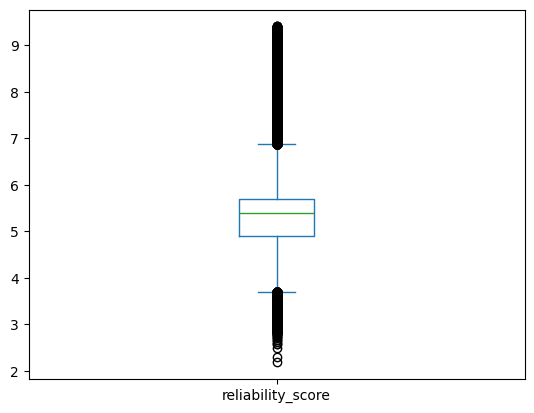

In [125]:
df['reliability_score'].plot.box()

In [126]:
df[df['reliability_score']>6].sort_values(by='reliability_score', ascending=False)

,id_x,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,...,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,cluster_members,cluster_representative,id_y,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score,reliability_score
68981,uniprot_010863,1,1,1,9.400000e-122,0.574587,4.600000e-123,0.862101,1,1,...,A0A290U6M6,0.007651,0.992349,uniprot_010863,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255,9.408604
104242,uniprot_065742,1,1,1,5.000000e-122,0.575909,1.500000e-120,0.844162,1,1,...,K7PRF2,0.007671,0.992329,uniprot_065742,uniprot_048345,uniprot_048345,0.032755,D0UZK2,0.997482,9.407129
52252,phytozome_001109,1,1,1,5.100000e-122,0.575867,1.500000e-120,0.844162,1,1,...,K7PRF2,0.007671,0.992329,phytozome_001109,uniprot_048345,uniprot_048345,0.032755,D0UZK2,0.997482,9.407088
100956,uniprot_060641,1,1,1,3.600000e-120,0.566951,2.600000e-123,0.863869,1,1,...,E5GAF4,0.006120,0.993880,uniprot_060641,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255,9.404245
81898,uniprot_030656,1,1,1,7.900000e-120,0.565305,1.000000e-124,0.873969,1,1,...,A0A482AJV9,0.000000,1.000000,uniprot_030656,uniprot_076938,uniprot_076938,0.256860,A0A076GAU5,0.980255,9.401211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107827,uniprot_071347,1,1,0,4.300000e-53,0.243455,NaN,0.000000,1,0,...,Q8BLN5,0.065676,0.934324,uniprot_071347,uniprot_060123,uniprot_060123,0.552238,P84466,0.957549,6.000050
128520,uniprot_103952,1,1,0,8.700000e-56,0.256447,NaN,0.000000,1,0,...,P84466,0.093436,0.906564,uniprot_103952,uniprot_079687,uniprot_079687,0.360218,P84466,0.972310,6.000042
27800,tsa_030040,0,1,0,3.500000e-50,0.229418,2.100000e-57,0.393455,1,1,...,A0A076L4Z9,0.112519,0.887481,tsa_030040,uniprot_068336,uniprot_068336,0.971211,Q8W1D0,0.925342,6.000042
53773,phytozome_003402,1,1,0,3.600000e-49,0.224536,NaN,0.000000,1,0,...,Q9FJV8,0.042896,0.957104,phytozome_003402,uniprot_068735,uniprot_068735,0.349218,O82146,0.973155,6.000008


In [127]:
df[df['ss_closest_char_tps'] == df['esm_closest_char_tps']]

,id_x,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,...,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,cluster_members,cluster_representative,id_y,distance_to_closest_characterized,closest_characterized_leaf,phylo_distance_score,reliability_score
39,onekp_000061,0,1,0,3.900000e-48,0.219546,NaN,0.000000,1,0,...,D0VFU8,0.048400,0.951600,onekp_000061,uniprot_050104,uniprot_050104,0.304010,P53800,0.976630,4.970292
96,onekp_000169,0,1,1,8.500000e-84,0.391533,4.900000e-86,0.597817,1,1,...,A0A6B8N4Y9,0.067306,0.932694,onekp_000169,onekp_005916,onekp_005916,0.801540,A0A6B8N4Y9,0.938385,7.688712
104,onekp_000179,0,1,1,4.100000e-73,0.340010,3.200000e-77,0.534900,1,1,...,A0A6C0TL59,0.076250,0.923750,onekp_000179,tsa_018280,tsa_018280,0.457058,A0A6C0TLK1,0.964865,7.468305
111,onekp_000189,0,1,1,2.300000e-110,0.519662,1.100000e-103,0.723785,1,1,...,G8H5M8,0.067282,0.932718,onekp_000189,uniprot_062344,uniprot_062344,0.311280,H9C6R1,0.976072,7.894689
112,onekp_000190,0,1,1,2.100000e-104,0.490916,2.100000e-105,0.736056,1,1,...,G1JUH5,0.071479,0.928521,onekp_000190,uniprot_092504,uniprot_092504,0.806620,Q6PWU2,0.937994,7.922699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586383,bfd_246616,0,0,1,NaN,0.000000,2.200000e-21,0.136360,0,1,...,P21684,0.192409,0.807591,bfd_246616,bfd_258332,bfd_258332,4.413707,B3TPQ7,0.660714,4.363196
595718,bfd_259403,0,0,1,NaN,0.000000,1.400000e-21,0.137761,0,1,...,P21684,0.199225,0.800775,bfd_259403,bfd_259289,bfd_259289,5.063208,B3TPQ7,0.610786,4.332123
604750,bfd_270471,0,0,1,NaN,0.000000,2.200000e-20,0.129223,0,1,...,P21684,0.298532,0.701468,bfd_270471,bfd_270447,bfd_270447,4.524610,B3TPQ7,0.652189,4.232071
605733,bfd_271532,0,0,1,NaN,0.000000,5.900000e-15,0.090477,0,1,...,P21684,0.171962,0.828038,bfd_271532,bfd_253323,bfd_253323,2.891729,J7LH11,0.777710,4.454755


In [102]:
df[df['ss']<30]

,id,methionin,observed_pfam_architecture,observed_supfam_architecture,strongest_pfam_hit_cevalue,strongest_pfam_hit_cevalue_neg_log_norm,strongest_supfam_hit_cevalue,strongest_supfam_hit_cevalue_neg_log_norm,has_pfam_hit,has_supfam_hit,ss_closest_char_tps,ss,ss_distance_score,esm_distance,esm_closest_char_tps,esm_distance_norm,esm_closeness_score,reliability_score
8001,onekp_013790,0,0,1,NaN,0.000000,9.300000e-22,0.139029,0,1,G1JUH1,9.722,0.015172,1.098210,A0A7D0AGU9,0.166061,0.833939,2.988140
39210,tsa_047488,0,0,1,NaN,0.000000,2.300000e-40,0.271835,0,1,A0A4Y5QVX4,9.756,0.015543,0.642119,A0A7D0AGU9,0.097095,0.902905,3.190283
39211,tsa_047489,1,0,1,NaN,0.000000,4.300000e-41,0.277033,0,1,A7IZZ1,9.756,0.015543,0.671469,A0A7D0AGU9,0.101533,0.898467,4.191043
39216,tsa_047494,1,0,1,NaN,0.000000,4.300000e-41,0.277033,0,1,A0A4Y5QVX4,9.756,0.015543,0.657767,A0A7D0AGU9,0.099461,0.900539,4.193115
39217,tsa_047495,1,0,1,NaN,0.000000,4.100000e-41,0.277181,0,1,A7IZZ1,9.756,0.015543,0.673053,A0A7D0AGU9,0.101773,0.898227,4.190951
69837,uniprot_012156,1,0,1,6.700000e-94,0.440259,1.500000e-90,0.630036,1,1,J7LH11,9.524,0.013009,0.567650,R9QMW4,0.085835,0.914165,5.997469
110524,uniprot_075366,1,1,1,1.200000e-133,0.631948,9.600000e-43,0.288819,1,1,A0A059PYD5,9.259,0.010114,0.607604,BDI63109.1,0.091876,0.908124,6.839005
124573,uniprot_098198,1,1,1,1.900000e-35,0.158356,7.600000e-41,0.275268,1,1,G5CV48,9.091,0.008279,0.751851,A0A142BX70,0.113688,0.886312,6.328215
129884,uniprot_106531,1,1,1,9.700000e-21,0.087423,1.600000e-23,0.151623,1,1,I7H727,9.375,0.011382,0.657161,A0A385AJM7,0.099370,0.900630,6.151057
154975,uniprot_139615,1,0,1,NaN,0.000000,2.700000e-21,0.135726,0,1,G2P5T1,9.639,0.014265,1.669472,A0A140AZ69,0.252442,0.747558,3.897548
